# Implémentation du schéma de Rusanov

## Importations

In [1]:
import math as math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

import numpy as np
import imageio

import time

## Paramètres du problème

In [2]:
g=1 # Constante gravitationnelle

xMin = 0
xMax = 10

N=32
h=(xMax-xMin)/(N+1) # Pas du maillage spatial

Tmax= 60 # Temps Max
t=0 # Temps dans la simulation
n=0 # Nombre d'itérations

X = np.linspace(xMin,xMax,N+2) # Discrétisation de [xMin, xMax]

## Nombre de sauvegardes durant la simulation

In [3]:
nSauvegarde=300
tSauvegarde=[False for i in range(nSauvegarde)]
images=[]
j=0 #Nombre de sauvegardes déjà effectuées

## Conditions initiales et Topographie

In [9]:
# Tableau avec 2 lignes et N+2 colonnes : discrétisation du vecteur (h, q) en N parties + 2 aux bords

U = np.ones((2,N+2))
Uprime = np.zeros((2,N+2)) # Pour faire les calculs dans la boucle
Z = np.zeros((1,N+2))

#Conditions initiales spéciales avec Z en pente au bord du rivage et h en escalier
# for i in range(N+2):
#     U[1,i]=1
#     if(X[i]<2):
#         U[0,i] = 1.5
#     elif(X[i]<5):
#         U[0,i] = .75
#     elif(X[i]<7.5):
#         U[0,i] = .75 - ( .3 * (X[i] - 5) ) 
#     else:
#         U[0,i] = 0

# # Topographie Z
# for i in range(N+2):
#     if(X[i]<5):
#         Z[0,i] = 0
#     else:
#         Z[0,i] = .3 * (X[i] - 5)

        
#Conditions initiales avec Z constant = .5  et h en escalier
Z[0,(N+2)//2:N+2]= .5

U[0, 0 :(N+2)//2]= 1.5
U[0,(N+2)//2:N+2]=  .5

## Affichage des images

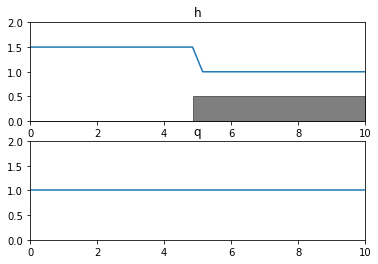

In [10]:
def affiche_U():
    
    fig, axs = plt.subplots(2,1)
    
    ###
    h_z = [U[0,i]+Z[0,i] for i in range(N+2)]
    axs[0].plot(X,h_z)
    ###
    
    axs[0].set_title("h")
    axs[0].set_xlim([0,10])
    axs[0].set_ylim([0,2])
    axs[0].fill_between(X, Z[0], step="pre", alpha=0.5, color="black")
    
    axs[1].plot(X,U[1,:])
    axs[1].set_title("q")
    axs[1].set_xlim([0,10])
    axs[1].set_ylim([0,2])
        
    plt.show()
    
affiche_U()

## Sauvegarde des images

In [12]:
def enregistre_U(n,t):

    t=round(t,4) # Troncature de t après la 4eme décimale
    
    fig, axs = plt.subplots(2,1)
    fig.suptitle("t="+str(t),fontsize=16)

    ###
    h_z = U[0,:]+Z[0,:]
    axs[0].plot(X,h_z)
    ###
    
    axs[0].set_title("h")
    axs[0].set_xlim([0,10])
    axs[0].set_ylim([0,2])
    axs[0].fill_between(X, Z[0] , step="pre", alpha=0.5,color="black")
    
    axs[1].plot(X,U[1,:])
    axs[1].set_title("q")
    axs[1].set_xlim([0,10])
    axs[1].set_ylim([0,2])
        
    # To remove the huge white borders
    axs[0].margins(0)
    axs[1].margins(0)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    images.append(image_from_plot)
    
    #Sauvegarde dans un fichier png
    #plt.savefig("etape"+str(n)+".png")
    
    plt.close()

## Fonctions qui interviennent dans le schéma :

In [13]:
def F(U):
    """
    """
    return np.array([U[1], (U[1]**2)/U[0] + g*(U[0]**2)/2])

def P(x):
    """
    """
    return( .5 * g * x * x )

def vmax( x , y ):
    """
    """
    res = abs(x[1]/x[0] + math.sqrt(g*x[0]))
    
    if (abs(x[1]/x[0] - math.sqrt(g*x[0])) > res):
        res = abs(x[1]/x[0] - math.sqrt(g*x[0]))
        
    if (abs(y[1]/y[0] + math.sqrt(g*y[0])) > res):
        res = abs(y[1]/y[0] + math.sqrt(g*y[0]))
    
    if (abs(y[1]/y[0] - math.sqrt(g*y[0])) > res):
        res = abs(y[1]/y[0] - math.sqrt(g*y[0]))
                  
    return res

def F_ronde( x , y ):
    """
    """
    return ( (F(x)+F(y)) / 2 - vmax(x,y)*(y-x)/2 )

# Résolution :

In [14]:
enregistre_U(n,t)

print("Calcul en cours ...")
while(t<Tmax): # Tant que le temps max n'est pas atteint :

    #print("t="+str(round(t,4)))
    #print("n="+str(n))
    #affiche_U()

    M = vmax(U[:,1],U[:,2])
    
    for i in range(2, N+1):
        M = max(M, vmax(U[:,i],U[:,i+1]) )
    
    # Pour assurer la stabilité, tau doit être inférieur à h/(2* max(vp))
    tau = h/(2*M)
    
    h_12_G=[]
    h_12_D=[]
    
    #Calcul de tous les h reconditionnés à l'avance pour pas calculer de doublons
    for i in range(1, N+1):
        h_12_G.append(max(U[0, i ]+Z[0, i ] - max(Z[0,i],Z[0,i+1]) , 0 ) )
        h_12_D.append(max(U[0,i+1]+Z[0,i+1] - max(Z[0,i],Z[0,i+1]) , 0 ) )
        
    for i in range(1, N+1):
        
        #Vecteurs reconstitués
        U_plus_12_G = np.array([ h_12_G[i] , U[1,i] ])
        U_plus_12_D = np.array([ h_12_D[i] , U[1,i] ])
        
        U_moins_12_G = np.array([ h_12_G[i-1] , U[1,i-1] ])
        U_moins_12_D = np.array([ h_12_D[i-1] , U[1,i-1] ])
        
        # Dernière équation avant le 3.3 du pdf code C saintvenant
        F_plus_12 = F_ronde( U_plus_12_G , U_plus_12_D )
        F_moins_12 = F_ronde( U_moins_12_G , U_moins_12_D )
        
        # Équation (33)
        S_plus_12_G = np.array([ 0 , P(U[0,i]) - P(h_12_G[i]) ])
        S_moins_12_D = np.array([ 0 , P(U[0,i]) - P(h_12_D[i-1]) ])
        
        # Équation (32)
        F_plus_12_G = F_plus_12 + S_plus_12_G
        F_moins_12_D = F_moins_12 + S_moins_12_D
        
                
        Uprime[:,i] = U[:,i] - tau/h * (F_plus_12_G - F_moins_12_D )
          
    
    U = Uprime
    
    # Conditions aux bords
    U[:,0] = U[:,1]
    U[:,N+1] = U[:,N]

    t+=tau
    n+=1
    
    if (t > Tmax/nSauvegarde*j and (j<nSauvegarde) and (not tSauvegarde[j])):
        enregistre_U(n,t)
        #affiche_U()
        tSauvegarde[j]=True
        j+=1

print("Nombre d'itérations : " + str(n))

imageio.mimsave('movie_fond.gif', images)
print("Gif Sauvegardé dans le dossier sous le nom : movie_fond.gif")

Calcul en cours ...


IndexError: list index out of range